# Your name:

# Starter Code

This notebook implements starter code to help you get started with the assignment. If you have a personal GPU, copy this starter code to another directory and run this notebook using your personal GPU. In that case, the docker we provide will not support PyTorch with GPU, and you can create your own virtual environment (e.g., conda) with PyTorch support (https://pytorch.org/get-started/locally/). 

To run this notebook you must __first create a folder called `./dataset` and download all the data files from the Kaggle competition page__.

In [4]:
import time
import os

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.optim as optim
%matplotlib inline

log_interval = 1000,
epochs = 1

params = {
    'log_interval': 1000,
    'epochs': 1
}

In [5]:
bypass_cuda=True

# GPU setup
use_cuda = torch.cuda.is_available()
print("Using {}".format('GPU' if use_cuda else 'CPU'))

Using GPU


Running batch-size sweep...  [1, 10, 100, 1000, 10000, 100000, 100000, 200000, 500000, 1000000] @ matrix size 16 x 16 Average count: 10
- 0 %
- 10 %
- 20 %
- 30 %
- 40 %
- 50 %
- 60 %
- 70 %
- 80 %
- 90 %
- 100%
Running mat-size sweep...  [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048] @ batch size 1 Average count: 10
- 0 %
- 9 %
- 18 %
- 27 %
- 36 %
- 45 %
- 54 %
- 63 %
- 72 %
- 81 %
- 90 %
- 100%
Calculating performance efficiency and roofline.


[Text(0, 0.5, 'Utilization (%)'), Text(0.5, 0, 'Matrix dimension m')]

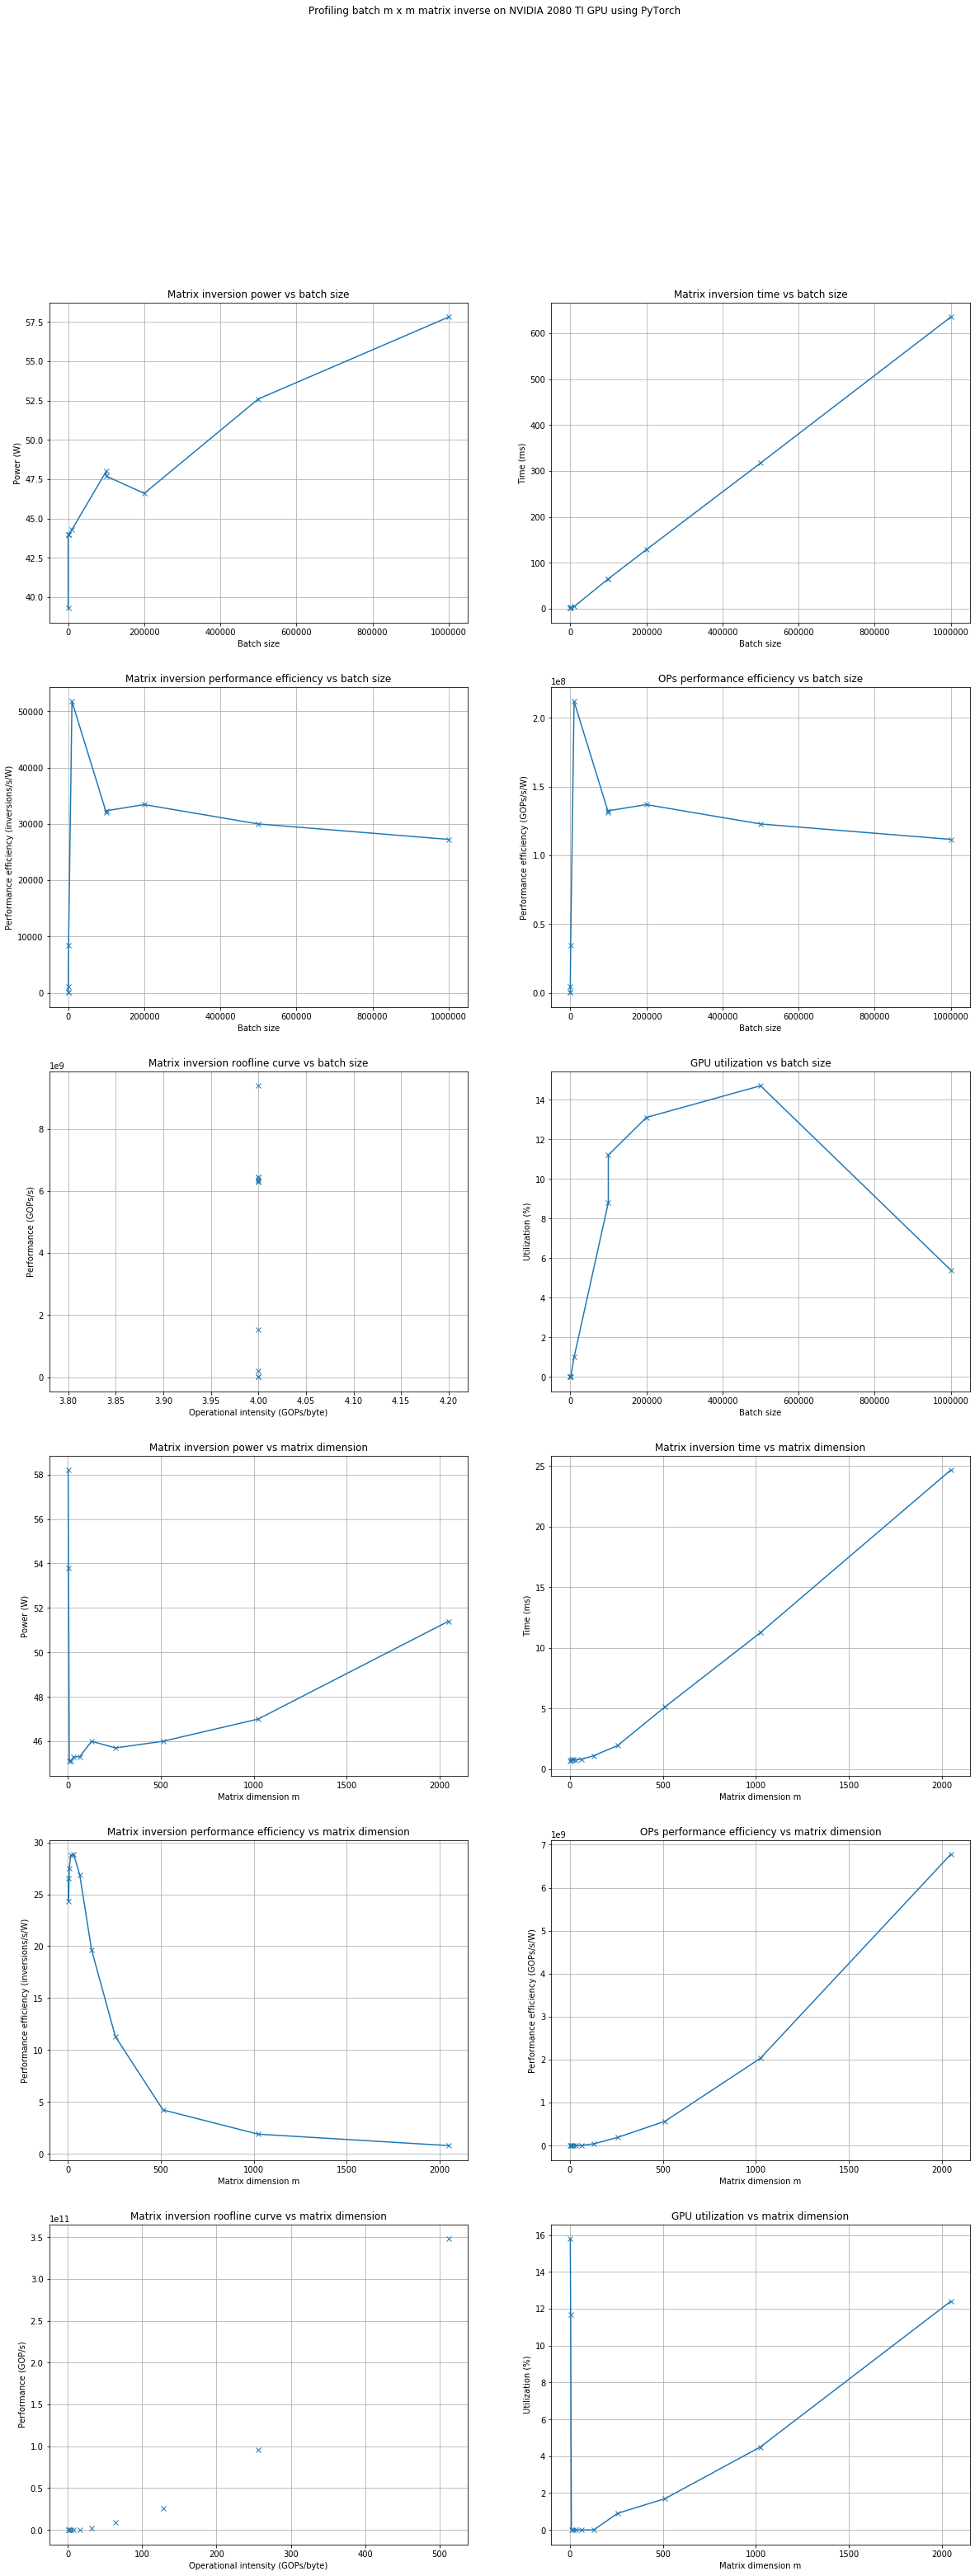

In [25]:
import time
import os

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
import subprocess

def profile_inverse(batch_size, mat_size, dtype):

    #sudo nvidia-smi -pl 125.00



    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)

    #torch.cuda.synchronize()

    ngpu = torch.cuda.device_count()

    #print("Running")

    batch = torch.rand(batch_size,mat_size,mat_size)    
    
    start.record()

    # This is the allocation to each GPU.
    if dtype == torch.int16:
        print("int16")
        batch = batch.type(torch.int16).cuda()
    elif dtype == torch.int32:
        batch = batch.type(torch.int32).cuda()
    elif dtype == torch.float32:
        batch = batch.cuda()
    elif dtype == torch.float64:
        batch = batch.type(torch.float64).cuda()

    # per the matmul on multiple GPUs post this should already be in parallel
    # but doesnt seem to be based on watch nvidia-smi
    C = torch.inverse(batch).cpu()

    end.record()

    # Waits for everything to finish running
    torch.cuda.synchronize()
    nvidia_metrics = subprocess.check_output(['nvidia-smi']).decode("'UTF-8'").split()
    pwr = float([x for x in nvidia_metrics if x[-1] == 'W'][0][0:-1])
    util = float([x for x in nvidia_metrics if x[-1] == '%'][1][0:-1])

    
    try:
        del batch
        del C
    except NameError:
        pass
        #print("Nothing to delete.")    
    
    torch.cuda.synchronize()
    torch.cuda.empty_cache()    
    
    return pwr, start.elapsed_time(end), util
    
    #print(start.elapsed_time(end))  # milliseconds
    #print(pwr)

def profile_inverse_average(batch_size, mat_size, num_average, it_count, it_total, dtype):
    
    pwr_avg = 0.0
    time_avg = 0.0
    util_avg = 0.0
    
    for idx in range(num_average):
        succ = False
        pwr = 0.0
        time = 0.0
        util = 0.0
#        while (not succ):
#            try:
        pwr, time, util = profile_inverse(batch_size, mat_size, dtype)
        succ = True
#            except RuntimeError as err:
#                print(err)
            
            
        pwr_avg = pwr_avg + pwr/float(num_average)
        time_avg = time_avg + time/float(num_average)
        util_avg = util_avg + util/float(num_average)
       
    print("-",int(100.0*float(it_count)/float(it_total)),"%")
        
    return pwr_avg, time_avg, util_avg
    
#profile_inverse(1000000, 16)

if (True):

    dtype = torch.float32
    
    num_average = 10
    
    fixed_mat_size = 16
    fixed_batch_size = 1
    batch_size_range = [1,10,100,1000,10000,100000,100000,200000,500000,1000000]
    num_batch = len(batch_size_range)
    mat_size_range = [2,4,8,16, 32, 64, 128, 256, 512, 1024, 2048]
    num_mat_size = len(mat_size_range)

    result_batch_sweep_pwr = []
    result_batch_sweep_time = []
    result_batch_sweep_util = []    
    result_batch_sweep_inv = []    
    result_batch_sweep_invsw = []
    result_batch_sweep_kops = []    
    result_batch_sweep_kopsw = [] 
    result_batch_sweep_bytes = []        
    result_batch_sweep_opint = []      
    
    result_mat_size_sweep_pwr = []
    result_mat_size_sweep_time = []
    result_mat_size_sweep_util = []    
    result_mat_size_sweep_invs = []
    result_mat_size_sweep_invsw = []    
    result_mat_size_sweep_kops = []     
    result_mat_size_sweep_kopsw = []  
    result_mat_size_sweep_bytes = []         
    result_mat_size_sweep_opint = []             
    

    # Batch size sweep
    print("Running batch-size sweep... ", batch_size_range, "@ matrix size", fixed_mat_size, "x", fixed_mat_size,"Average count:",num_average)
    result_batch_sweep_pwr, result_batch_sweep_time, result_batch_sweep_util = map(list, zip(*[profile_inverse_average(batch_size_range[bdx],fixed_mat_size,10, bdx, num_batch, dtype) for bdx in range(num_batch)]))
    print("-","100%")
    print("Running mat-size sweep... ", mat_size_range, "@ batch size", fixed_batch_size,"Average count:",num_average)
    result_mat_size_sweep_pwr, result_mat_size_sweep_time, result_mat_size_sweep_util = map(list, zip(*[profile_inverse_average(fixed_batch_size,mat_size_range[mdx],10, mdx, num_mat_size, dtype) for mdx in range(num_mat_size)]))
    print("-","100%")
    
    print("Calculating performance efficiency and roofline.")
    result_batch_sweep_inv = [float(batch_size_range[bdx]) for bdx in range(num_batch)]
    result_batch_sweep_invsw = [1.0e3*result_batch_sweep_inv[bdx]/result_batch_sweep_pwr[bdx]/result_batch_sweep_time[bdx] for bdx in range(num_batch)]
    result_batch_sweep_kops = [1.0e3*result_batch_sweep_inv[bdx] * float(fixed_mat_size**3)/result_batch_sweep_time[bdx] for bdx in range(num_batch)]
    result_batch_sweep_kopsw = [result_batch_sweep_kops[bdx]/result_batch_sweep_pwr[bdx] for bdx in range(num_batch)]
    result_batch_sweep_bytes = [bs * fixed_mat_size * fixed_mat_size * 4 for bs in batch_size_range]
    result_batch_sweep_opint = [result_batch_sweep_inv[bdx] * float(fixed_mat_size**3)/float(result_batch_sweep_bytes[bdx]) for bdx in range(num_batch)]
    
    result_mat_size_sweep_inv = [float(fixed_batch_size) for mdx in range(num_mat_size)]    
    result_mat_size_sweep_invsw = [1.0e3*result_mat_size_sweep_inv[mdx]/result_mat_size_sweep_pwr[mdx]/result_mat_size_sweep_time[mdx] for mdx in range(num_mat_size)]
    result_mat_size_sweep_kops = [1.0e3*result_mat_size_sweep_inv[mdx] * float(mat_size_range[mdx]**3)/result_mat_size_sweep_time[mdx] for mdx in range(num_mat_size)]
    result_mat_size_sweep_kopsw = [result_mat_size_sweep_kops[mdx]/result_mat_size_sweep_pwr[mdx] for mdx in range(num_mat_size)]
    result_mat_size_sweep_bytes = [fixed_batch_size * ms * ms * 4 for ms in mat_size_range]
    result_mat_size_sweep_opint = [result_mat_size_sweep_inv[mdx] * float(mat_size_range[mdx]**3)/float(result_mat_size_sweep_bytes[mdx]) for mdx in range(num_mat_size)]
    
    
# Display batch size sweep
fig, axs = plt.subplots(6, 2, figsize=(20,50))
fig.suptitle('Profiling batch m x m matrix inverse on NVIDIA 2080 TI GPU using PyTorch')
# - Matrix inversion power vs batch size
axs[0, 0].plot(batch_size_range, result_batch_sweep_pwr, marker="x")
axs[0, 0].grid("on")
axs[0, 0].set_title('Matrix inversion power vs batch size')
axs[0, 0].set(xlabel='Batch size', ylabel='Power (W)')
# - Matrix inversion time vs batch size
axs[0, 1].plot(batch_size_range, result_batch_sweep_time, marker="x")
axs[0, 1].grid("on")
axs[0, 1].set_title('Matrix inversion time vs batch size')
axs[0, 1].set(xlabel='Batch size', ylabel='Time (ms)')
# - Matrix inversion performance efficiency vs batch size
axs[1, 0].plot(batch_size_range, result_batch_sweep_invsw, marker="x")
axs[1, 0].grid("on")
axs[1, 0].set_title('Matrix inversion performance efficiency vs batch size')
axs[1, 0].set(xlabel='Batch size', ylabel='Performance efficiency (inversions/s/W)')
# - GOPS performance efficiency vs batch size
axs[1, 1].plot(batch_size_range, result_batch_sweep_kopsw, marker="x")
axs[1, 1].grid("on")
axs[1, 1].set_title('OPs performance efficiency vs batch size')
axs[1, 1].set(xlabel='Batch size', ylabel='Performance efficiency (GOPs/s/W)')
# - GOPs roofline curve vs batch size
axs[2, 0].plot(result_batch_sweep_opint, result_batch_sweep_kops, marker="x", linestyle='None')
axs[2, 0].grid("on")
axs[2, 0].set_title('Matrix inversion roofline curve vs batch size')
axs[2, 0].set(xlabel='Operational intensity (GOPs/byte)', ylabel='Performance (GOPs/s)')
# - GPU utilization vs batch size
axs[2, 1].plot(batch_size_range, result_batch_sweep_util, marker="x")
axs[2, 1].grid("on")
axs[2, 1].set_title('GPU utilization vs batch size')
axs[2, 1].set(xlabel='Batch size', ylabel='Utilization (%)')


# Display matrix size sweep
# - Matrix inversion power vs matrix dimension
axs[3, 0].plot(mat_size_range, result_mat_size_sweep_pwr, marker="x")
axs[3, 0].grid("on")
axs[3, 0].set_title('Matrix inversion power vs matrix dimension')
axs[3, 0].set(xlabel='Matrix dimension m', ylabel='Power (W)')
# - Matrix inversion time vs matrix dimension
axs[3, 1].plot(mat_size_range, result_mat_size_sweep_time, marker="x")
axs[3, 1].grid("on")
axs[3, 1].set_title('Matrix inversion time vs matrix dimension')
axs[3, 1].set(xlabel='Matrix dimension m', ylabel='Time (ms)')
# - Matrix inversion performance efficiency vs matrix dimension
axs[4, 0].plot(mat_size_range, result_mat_size_sweep_invsw, marker="x")
axs[4, 0].grid("on")
axs[4, 0].set_title('Matrix inversion performance efficiency vs matrix dimension')
axs[4, 0].set(xlabel='Matrix dimension m', ylabel='Performance efficiency (inversions/s/W)')
# - GOPs performance efficiency vs matrix dimension
axs[4, 1].plot(mat_size_range, result_mat_size_sweep_kopsw, marker="x")
axs[4, 1].grid("on")
axs[4, 1].set_title('OPs performance efficiency vs matrix dimension')
axs[4, 1].set(xlabel='Matrix dimension m', ylabel='Performance efficiency (GOPs/s/W)')
# - Matrix inversion roofline curve vs matrix dimension
axs[5, 0].plot(result_mat_size_sweep_opint, result_mat_size_sweep_kops, marker="x", linestyle='None')
axs[5, 0].grid("on")
axs[5, 0].set_title('Matrix inversion roofline curve vs matrix dimension')
axs[5, 0].set(xlabel='Operational intensity (GOPs/byte)', ylabel='Performance (GOP/s)')
# - GPU utilization vs matrix dimension
axs[5, 1].plot(mat_size_range, result_mat_size_sweep_util, marker="x")
axs[5, 1].grid("on")
axs[5, 1].set_title('GPU utilization vs matrix dimension')
axs[5, 1].set(xlabel='Matrix dimension m', ylabel='Utilization (%)')

In [33]:
[1.0e3*result_batch_sweep_inv[bdx]/result_batch_sweep_time[bdx] for bdx in range(num_batch)]

[1329.1311348639729,
 5287.665968942433,
 50688.38913176859,
 370391.00502906664,
 2291791.6535577113,
 1537437.6783921586,
 1541801.5462667858,
 1557196.1155636448,
 1576862.7877888882,
 1574524.0168921517]

In [34]:
result_batch_sweep_pwr


[39.300000000000004,
 43.99999999999999,
 43.99999999999999,
 43.99999999999999,
 44.3,
 47.99999999999999,
 47.699999999999996,
 46.6,
 52.599999999999994,
 57.79999999999999]

In [35]:
result_batch_sweep_kops

[5444121.128402833,
 21658279.808788206,
 207619641.88372415,
 1517121556.599057,
 9387178612.972385,
 6297344730.694282,
 6315219133.508755,
 6378275289.348689,
 6458829978.783286,
 6449250373.190253]

In [36]:
result_batch_sweep_kopsw

[138527.2551756446,
 492233.63201791386,
 4718628.224630095,
 34480035.3772513,
 211900194.42375588,
 131194681.88946421,
 132394531.10081248,
 136872860.28645256,
 122791444.46356058,
 111578726.17976218]

In [37]:
result_batch_sweep_invsw

[33.820130658116355,
 120.1742265668735,
 1152.0088439038318,
 8417.977387024244,
 51733.44590423728,
 32029.951633169974,
 32322.883569534297,
 33416.22565587221,
 29978.37999598647,
 27240.899946231002]

In [38]:
result_batch_sweep_util

[0.0,
 0.0,
 0.0,
 0.0,
 0.9999999999999999,
 8.8,
 11.2,
 13.100000000000001,
 14.700000000000001,
 5.4]

In [39]:
result_batch_sweep_opint

[4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0]

In [40]:
[result_batch_sweep_inv[bdx]/float(result_batch_sweep_bytes[bdx]) for bdx in range(num_batch)]

[0.0009765625,
 0.0009765625,
 0.0009765625,
 0.0009765625,
 0.0009765625,
 0.0009765625,
 0.0009765625,
 0.0009765625,
 0.0009765625,
 0.0009765625]